# FastClouds
This is my project for the first week fo the fast.ai course v5. It is a re-implementation of Jeremy's 'bird vs forests' notebook. This is for my own learning experience.

There are three broad categorised of clouds as per the work of Luke Howard in "Essay of the Modifications of Clouds" (1803) (https://www.weather.gov/jetstream/corefour): Cirrus, Cumulus, Stratus

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/lib/kaggle/gcp.py
/kaggle/working/cirrocumulus.jpg
/kaggle/working/nimbostratus.jpg
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/cumulus.jpg
/kaggle/working/cirrus.jpg


In [3]:
# import shutil

# shutil.rmtree('./cloud_types/')

In [4]:
!pip install -Uqq fastai

In [5]:
from fastcore.all import *
import time

In [6]:
def search_duckduckgo(term, max_images=200):
    """
    Search duckduckgo images for the term
    """
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(),{'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data = params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [13]:
urls = search_duckduckgo('cirrus clouds', max_images = 2)
urls[1]

'https://images.fineartamerica.com/images-medium-large-5/cirrus-clouds-keith-kentscience-photo-library.jpg'

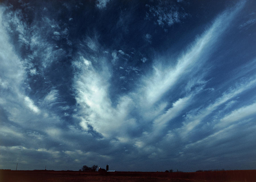

In [14]:
from fastdownload import download_url
dest = 'cirrus.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now lets od the same for another cloud genus

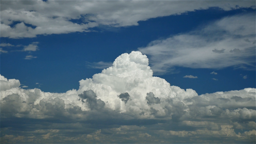

In [15]:
download_url(search_duckduckgo('cumulus clouds', max_images=1)[0], 'cumulus.jpg', show_progress = False)
Image.open('cumulus.jpg').to_thumb(256,256)

In [23]:
searches = 'cirrus', 'stratus', 'cumulus'
path = Path('cloud_types')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_duckduckgo(f'{o} clouds', max_images=400))
    resize_images(path/o, max_size=400, dest=path/o)

In [24]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

## Train a model

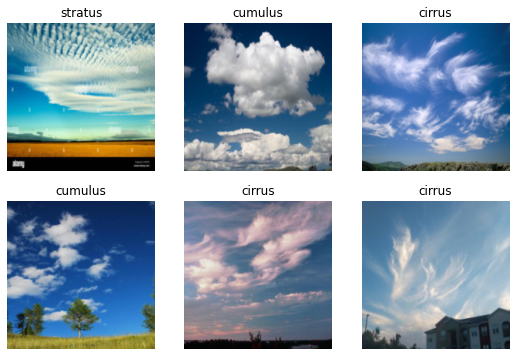

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [29]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# resnet18, resnet34, resnet50, resnet101, resnet152
# densenet121, densenet169, densenet201, densenet161
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.515935,0.803031,0.236735,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.795803,0.623807,0.195918,00:06
1,0.606876,0.576569,0.167347,00:07
2,0.482690,0.631473,0.155102,00:07
3,0.376530,0.652233,0.146939,00:06
4,0.316009,0.636460,0.155102,00:06
5,0.259649,0.679551,0.159184,00:06
6,0.213551,0.685194,0.151020,00:07
7,0.182853,0.658214,0.146939,00:06
8,0.156231,0.652461,0.142857,00:06
9,0.133763,0.651617,0.142857,00:06


# Use the model

In [30]:
is_cirrus, _, prob = learn.predict(PILImage.create('cirrus.jpg'))
print(f'This is a: {is_cirrus}')
print(f'Probability it is a cirrus: {prob[0]:.4f}')

This is a: cirrus
Probability it is a cirrus: 0.9998
